In [9]:
import numpy as np

In [10]:
class Dense_Layer:
    def __init__(self,ninputs,nneurons,l1_w=0,l1_b=0,l2_w=0,l2_b=0):
        # Initialising weights and biases
        self.weights = 0.1 * np.random.randn(ninputs,nneurons)
        self.biases = np.zeros((1,nneurons))
        # Regularization
        self.l1_w = l1_w
        self.l1_b = l1_b
        self.l2_w = l2_w
        self.l2_b = l2_b
        
    # Forward Propagation    
    def forward(self,inputs):
        self.output = np.dot(inputs,self.weights) + self.biases
        self.inputs = inputs
    
    # Backpropagation
    def backward(self,dvalues):
        self.dinputs = np.dot(dvalues,self.weights.T)
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
        
        if self.l1_w > 0:
            dl1w = np.ones_like(self.weights)
            dl1w[self.weights < 0] = -1
            self.dweights += dl1w
        if self.l1_b > 0:
            dl1b = np.ones_like(self.biases)
            dl1b[self.biases < 0] = -1
            self.dbiases += sl1b
        if self.l2_w > 0:
            self.dweights += self.weights * 2 * self.l2_w
        if self.l2_b > 0:
            self.dbiases += self.biases * 2 * self.l2_b

In [11]:
class Activation_Relu:
    def forward(self,inputs):
        self.output = np.maximum(0,inputs)
        self.inputs = inputs
    
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        

In [12]:
class Activation_Linear:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = inputs
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
    def predictions(self,outputs):
        return outputs

In [24]:
class MeanSquaredLoss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)

        data_loss = np.mean(sample_losses)

        return data_loss, self.regularization_loss()
    
    def regularization_loss(self):
        
        loss = 0
        for layer in self.trainable_layers:
            if layer.l1_w > 0:
                loss += layer.l1_w * np.sum(np.abs(layer.weights))
            if layer.l1_b > 0:
                loss += layer.l1_b * np.sum(np.abs(layer.biases))
            if layer.l2_w > 0:
                loss += layer.l2_w * np.sum(layer.weights * layer.weights)
            if layer.l2_b > 0:
                loss += layer.l2_b * np.sum(layer.biases * layer.biases)
        
        return loss
    
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers
    
    def forward(self,y_pred,y_true):
        sample_losses = np.mean((y_pred - y_true) ** 2)
        return sample_losses
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs /= samples

In [14]:
class Adam_Optimizer:
    def __init__(self,lr=0.001,decay_rate=0,epsilon= 1e-7,beta1=0.9,beta2=0.999):
        self.initiallr = lr
        self.currentlr = lr
        self.decay_rate = decay_rate
        self.iterations = 0
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
    
    def pre_update(self):
        self.currentlr = self.initiallr * (1/(1+(self.decay_rate * self.iterations)))

    def update_params(self,layer):
        
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            layer.weight_momentum = np.zeros_like(layer.weights)
            layer.bias_momentum = np.zeros_like(layer.biases)
            
        layer.weight_momentum = self.beta1 * layer.weight_momentum + (1-self.beta1) * layer.dweights
        layer.bias_momentum = self.beta1 * layer.bias_momentum + (1 - self.beta1) * layer.dbiases
        
        layer.weight_momentum_prime = layer.weight_momentum / (1 - self.beta1 ** (self.iterations + 1))
        layer.bias_momentum_prime = layer.bias_momentum / (1 - self.beta1 ** (self.iterations + 1))
        
        layer.weight_cache = layer.weight_cache * self.beta2 + (1-self.beta2) * (layer.dweights ** 2)
        layer.bias_cache = layer.bias_cache * self.beta2 + (1-self.beta2) * (layer.dbiases ** 2)
        
        layer.weight_cache_prime = layer.weight_cache / (1 - self.beta2 ** (self.iterations + 1))
        layer.bias_cache_prime = layer.bias_cache / (1 - self.beta2 ** (self.iterations + 1))

        layer.weights += - self.currentlr * layer.weight_momentum_prime  / (np.sqrt(layer.weight_cache_prime) + self.epsilon)
        layer.biases += -self.currentlr * layer.bias_momentum_prime / (np.sqrt(layer.bias_cache_prime) + self.epsilon)
        
    def post_update(self):
        self.iterations += 1

In [15]:
from nnfs.datasets import sine_data
import matplotlib.pyplot as plt
import time

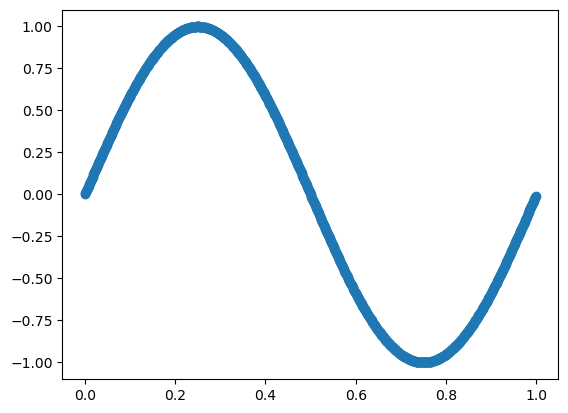

In [16]:
X,y = sine_data()
plt.scatter(X,y)

In [94]:
layer1 = Dense_Layer(1,64)
act_relu1 = Activation_Relu()
layer2 = Dense_Layer(64,64)
act_relu2 = Activation_Relu()
layer3 = Dense_Layer(64,1)
act_linear = Activation_Linear()
loss_func = MeanSquaredLoss()
optimizer = Adam_Optimizer(lr=0.005,decay_rate=1e-3)
precision = np.std(y)/250

for epoch in range(10001):
    layer1.forward(X)
    act_relu1.forward(layer1.output)
    layer2.forward(act_relu1.output)
    act_relu2.forward(layer2.output)
    layer3.forward(act_relu2.output)
    act_linear.forward(layer3.output)
    loss = loss_func.forward(act_linear.output,y)
    
    y_pred = act_linear.output
    accuracy = np.mean(np.absolute(y_pred - y) < precision)
    
    if epoch % 1000 == 0 :
        print(f"Epoch: {epoch}, Loss : {loss:.3f}, Accuracy: {accuracy:.3f}")
    loss_func.backward(act_linear.output,y)
    act_linear.backward(loss_func.dinputs)
    layer3.backward(act_linear.dinputs)
    act_relu2.backward(layer3.dinputs)
    layer2.backward(act_relu2.dinputs)
    act_relu1.backward(layer2.dinputs)
    layer1.backward(act_relu1.dinputs)
    
    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.update_params(layer3)
    optimizer.post_update()


Epoch: 0, Loss : 0.499, Accuracy: 0.002
Epoch: 1000, Loss : 0.000, Accuracy: 0.887
Epoch: 2000, Loss : 0.000, Accuracy: 0.926
Epoch: 3000, Loss : 0.000, Accuracy: 0.963
Epoch: 4000, Loss : 0.000, Accuracy: 0.960
Epoch: 5000, Loss : 0.000, Accuracy: 0.879
Epoch: 6000, Loss : 0.000, Accuracy: 0.918
Epoch: 7000, Loss : 0.000, Accuracy: 0.295
Epoch: 8000, Loss : 0.000, Accuracy: 0.977
Epoch: 9000, Loss : 0.000, Accuracy: 0.585
Epoch: 10000, Loss : 0.000, Accuracy: 0.976


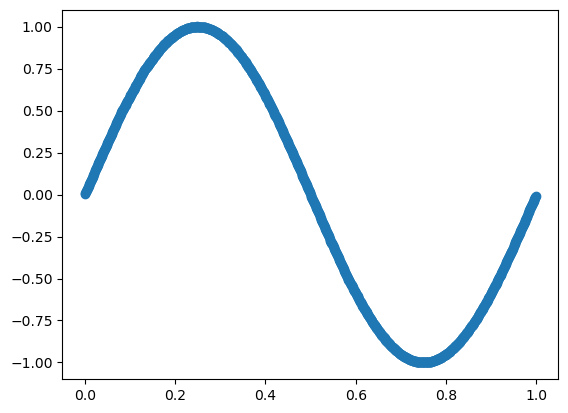

In [95]:
plt.scatter(X,y_pred)

In [26]:
class Model:
    def __init__(self):
        self.layers = []
    
    def add(self,layer):
        self.layers.append(layer)
        
    def set(self,*,loss,optimizer,accuracy):
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
    
    def train(self,X,y,*,epochs,print_every):
        self.accuracy.init(y)
        for epoch in range(1,epochs+1):
            output = self.forward(X)
            data_loss,regularization_loss = self.loss.calculate(output,y)
            loss = data_loss + regularization_loss
            
            predictions = self.output_activation.predictions(output)
            
            accuracy = self.accuracy.calculate(predictions,y)
            
            self.backward(output,y)
            
            self.optimizer.pre_update()
            for layer in self.trainable_layers:
                self.optimizer.update_params(layer)
            self.optimizer.post_update
            
            if not epoch % print_every:
                print(f'epoch: {epoch}, ' +
                f'acc: {accuracy:.3f}, ' +
                f'loss: {loss:.3f} (' +
                f'data_loss: {data_loss:.3f}, ' +
                f'reg_loss: {regularization_loss:.3f}), ' +
                f'lr: {self.optimizer.currentlr}')
        
    def finalize(self):
        self.input_layer = Input_Layer()
        self.trainable_layers = []
        nlayers = len(self.layers)
        
        for i in range(nlayers):
            if i==0 :
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]
            elif i < nlayers - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_activation = self.layers[i]
            
            if hasattr(self.layers[i],"weights"):
                self.trainable_layers.append(self.layers[i])
        self.loss.remember_trainable_layers(self.trainable_layers)   
            
    def forward(self,X):
        self.input_layer.forward(X)
        for layer in self.layers:
            layer.forward(layer.prev.output)
        return layer.output
    def backward(self,output,y):
        self.loss.backward(output,y)
        
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)
        
    

In [18]:
class Input_Layer:
    def forward(self,inputs):
        self.output = inputs

In [19]:
class Accuracy:
    def calculate(self,predictions,y):
        comparisions = self.compare(predictions,y)
        accuracy = np.mean(comparisions)
        return accuracy

In [20]:
class Accuracy_Regression(Accuracy):
    def __init__(self):
        self.precision = None
        
    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250

    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision

In [27]:
model = Model()
model.add(Dense_Layer(1,64))
model.add(Activation_Relu())
model.add(Dense_Layer(64,64))
model.add(Activation_Relu())
model.add(Dense_Layer(64,1))
model.add(Activation_Linear())

model.set(accuracy=Accuracy_Regression(),loss=MeanSquaredLoss(),optimizer=Adam_Optimizer(lr=0.005,decay_rate=1e-3))

model.finalize()

model.train(X,y,epochs=10001,print_every=1000)

epoch: 1000, acc: 0.687, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.005
epoch: 2000, acc: 0.724, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.005
epoch: 3000, acc: 0.785, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.005
epoch: 4000, acc: 0.123, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.005
epoch: 5000, acc: 0.823, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.005
epoch: 6000, acc: 0.824, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.005
epoch: 7000, acc: 0.119, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.005
epoch: 8000, acc: 0.681, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.005
epoch: 9000, acc: 0.843, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.005
epoch: 10000, acc: 0.835, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000), lr: 0.005
